In [2]:
import pandas as pd
import numpy as np
import re
import math
from cleantext import clean
import matplotlib.pyplot as plt
import nltk
from nltk.stem.snowball import SnowballStemmer
from collections import Counter

nltk.download('punkt')

#hej
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 150)


C:\Users\astri\AppData\Local\Temp\ipykernel_11480\2300219620.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\astri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
news_data = pd.read_csv('data.csv')
print(news_data.head())

   Unnamed: 0   id                domain        type  \
0           0  141               awm.com  unreliable   
1           1  256     beforeitsnews.com        fake   
2           2  700           cnnnext.com  unreliable   
3           3  768               awm.com  unreliable   
4           4  791  bipartisanreport.com   clickbait   

                                                                                                                           url  \
0                 http://awm.com/church-congregation-brings-gift-to-waitresses-working-on-christmas-eve-has-them-crying-video/   
1  http://beforeitsnews.com/awakening-start-here/2018/01/awakening-of-12-strands-of-dna-reconnecting-with-you-movie-10623.html   
2                                  http://www.cnnnext.com/video/18526/never-hike-alone-a-friday-the-13th-fan-film-full-movie-/   
3                           http://awm.com/elusive-alien-of-the-sea-caught-by-scientist-for-one-of-the-first-times-ever-video/   
4     http://

In [4]:
#Saving 'content' column into variable
content_column = news_data['content']

date = re.compile(r"(([0-9]{4}-(0[0-9]|1[0-2])-([0-2][0-9]|[3[01])|[a-z]{,9} [0-9]{1,2}, [0-9]{2,4})|\b(\w+\s)(\d{2})(th)?,?(\s\d{4})\b)")
#tjek om regex virker
#datoer?
#url = re.compile(r'(https?://)?(www\.)?\w+-?\.?\w+\.\w{2,3}/?')
content_column = content_column.apply(lambda x: re.sub(date,"_DATE_",x))
#^fanger flere urls end funktionen fra biblioteket (men får ikke nødvendigvis ender med )

#husk også at fjerne |-tegn

#Calling the clean method with appropriate arguments and assigning the result back to 'content_column'
content_column_cleaned = content_column.apply(lambda x : clean(x,
    #Tror vi skal ændre fix_unicode og to_ascii til true? eller bare slette dem
    fix_unicode=False,             # fix various unicode errors
    to_ascii=False,                # transliterate to closest ASCII representation
    lower=True,                    # lowercase text
    no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=True,                # replace all digits with a special token
    no_currency_symbols=True,      # replace all currency symbols with a special token
    no_punct=True,                 # remove punctuations
    replace_with_punct="",         # instead of removing punctuations you may replace them
    replace_with_url="_URL_",
    replace_with_email="_EMAIL_",
    replace_with_phone_number="_PHONE_",
    replace_with_number="_NUMBER_",
    replace_with_digit="0",
    replace_with_currency_symbol="_CUR_",
    lang="en"                    
))
print(content_column_cleaned.head())
#række med indeks 1: der er en url som ikke bliver fanget



0    sometimes the power of christmas will make you do wild and wonderful things you do not need to believe in the holy trinity to believe in the posit...
1    awakening of number strands of dna reconnecting with you movie of readers think this story is fact add your two cents headline bitcoin blockchain ...
2    never hike alone a friday the 00th fan film usa | number | number min a fan tribute to friday the 00th never hike alone follows an adventure never...
3    when a rare shark was caught scientists were left blundering for answers this shark has a unique feature and its not that it can survive at extrem...
4    donald trump has the unnerving ability to ability to create his own reality and convince millions of americans that what he says it is true the pr...
Name: content, dtype: object


In [5]:
#Tokenize
content_column_tokenized = content_column_cleaned.apply(lambda x: nltk.word_tokenize(x))
print(content_column_tokenized)


0      [sometimes, the, power, of, christmas, will, make, you, do, wild, and, wonderful, things, you, do, not, need, to, believe, in, the, holy, trinity,...
1      [awakening, of, number, strands, of, dna, reconnecting, with, you, movie, of, readers, think, this, story, is, fact, add, your, two, cents, headli...
2      [never, hike, alone, a, friday, the, 00th, fan, film, usa, |, number, |, number, min, a, fan, tribute, to, friday, the, 00th, never, hike, alone, ...
3      [when, a, rare, shark, was, caught, scientists, were, left, blundering, for, answers, this, shark, has, a, unique, feature, and, its, not, that, i...
4      [donald, trump, has, the, unnerving, ability, to, ability, to, create, his, own, reality, and, convince, millions, of, americans, that, what, he, ...
5      [republicans, and, democrats, alike, are, willing, to, turn, over, government, coffers, to, bezos, and, his, ilk, and, the, rights, of, the, peopl...
6      [could, you, imagine, waking, up, in, the, morgue, 

In [6]:
#Remove stopwords
stopwordsDF = pd.read_csv('stopwords.csv')  #571 stopord - den fra nltk har færre, men kan også bruge
stopwordsSeries = stopwordsDF.squeeze()
stopwords = set(stopwordsSeries)

def remove_stopwords(list):
     '''Returns a list containing a document with the stopwords removed'''
     return [word for word in list if word not in stopwords]

content_column_no_stopwords = content_column_tokenized.apply(lambda x: remove_stopwords(x))

def vocabulary_size(series):
    '''Computes the vocabulary size of a corpus by iterating through every word
    in every document in the corpus and adding it to a dictionary if it hasnt been seen before
    as well as incrementing a variable counting every unique word. Returns the unique_word_count
    and sorted list of words and their frequencies'''
    # Initialize a counter for unique words count and dictionary to store word frequencies
    unique_words_count = 0
    word_frequency = {}
    # Iterate through each element in the series
    for field in series:
        # Iterate through each word in the current element
        for word in field:
            if word in word_frequency: 
                # If word already in dict, increment its count
                word_frequency[word] += 1
            else:
                # If not add it to the dictionary with count 1 and increment unique_words_count
                word_frequency[word] = 1
                unique_words_count += 1
    # Sort the word_frequency dictionary by frequency in descending order
    sorted_word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)

    return unique_words_count, sorted_word_frequency

vocabulary_size_with_stopwords = vocabulary_size(content_column_tokenized)[0]
vocabulary_size_no_stopwords = vocabulary_size(content_column_no_stopwords)[0]
print("vocabulary size before removal of stopwords: ", vocabulary_size_with_stopwords)
print("vocabulary size after removal of stopwords: ", vocabulary_size_no_stopwords)

#Jeg har taget foreskellen ml antal ord før processing og efter of så divideret med
# antal ord til at starte med for at få reduction raten
def reduction_rate(after,before):
     '''Computes the reduction rate of the size of the vocabulary
     and returns this rounded to 3 decimal points'''
     return round((before - after)/before, 3)

print("Reduction rate of vocabulary size after removing stopwords:", reduction_rate(vocabulary_size_no_stopwords,vocabulary_size_with_stopwords))
#måske noget med at ordene er meget frekvente, så man kunne også kigge på reduktionen af antal ord.


vocabulary size before removal of stopwords:  16654
vocabulary size after removal of stopwords:  16168
Reduction rate of vocabulary size after removing stopwords: 0.029


In [7]:
#Stemming
stemmer = SnowballStemmer("english")

def list_stemmer (wordlist): #stemmer hvert ord i en liste
    '''Stems each word in the given input list and returns this'''
    stemmed_list = []
    for word in wordlist:
        stemmed_list.append(stemmer.stem(word))
    return stemmed_list

content_column_stemmed = content_column_no_stopwords.apply(lambda x:list_stemmer(x))

vocabulary_size_no_stopwords = vocabulary_size(content_column_no_stopwords)[0]
vocabulary_size_stemmed = vocabulary_size(content_column_stemmed)[0]
print("Vocabulary size before stemming: ", vocabulary_size_no_stopwords)
print("Vocabulary size after stemming: ", vocabulary_size_stemmed)
print("Reduction rate of vocabulary size after stemming:", reduction_rate(vocabulary_size_stemmed,vocabulary_size_no_stopwords))




Vocabulary size before stemming:  16168
Vocabulary size after stemming:  10804
Reduction rate of vocabulary size after stemming: 0.332


most frequent with stopwords ['the', 'of', 'to', 'and', 'a', 'in', 'is', 'that', 'number', 'for', 'it', 'are', 'on', 'with', 'this', 'you', 'as', 'be', 'i', 'by', 'have', 'not', 'was', 'from', 'at', 'or', 'we', 'they', 'its', 'but', 'your', 'has', 'an', 'their', 'can', 'all', 'will', 'more', 'about', 'if', 'us', 'one', 'what', 'who', 'he', 'were', 'which', 'so', 'there']
most frequent without stopwords ['a', 'number', 'people', 'trump', 'time', 'blockchain', 'url', 'market', 'government', 'state', 'president', 'life', 'make', 'world', 'things', 'years', 'bitcoin', 'states', 'stocks', 'fact', 'headline', 'year', 'good', 'exceed', 'searches', 'war', 'dont', 'power', 'back', 'obama', 'american', 'money', 'part', 'free', 'day', 'source', 'news', 'made', 'global', 'work', 'report', 'russia', 'long', 'public', 'research', 'numbernumber', 'policy', 'point', 'law']
most frequent stemmed ['a', 'number', 'time', 'peopl', 'state', 'trump', 'market', 'year', 'blockchain', 'make', 'url', 'thing', '

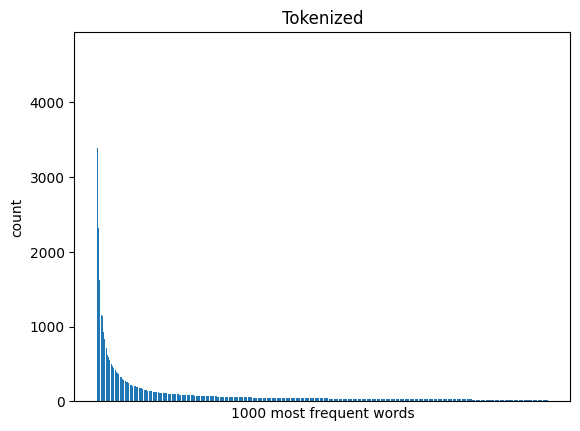

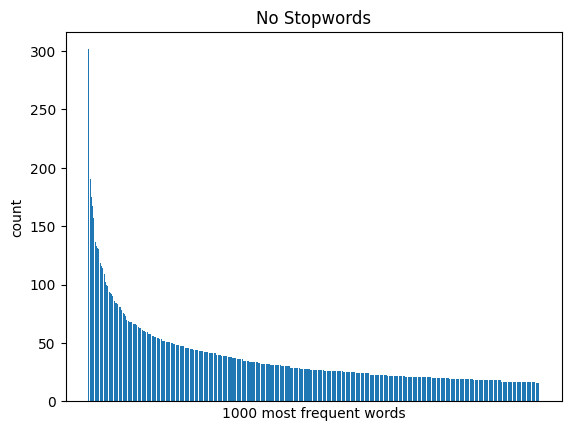

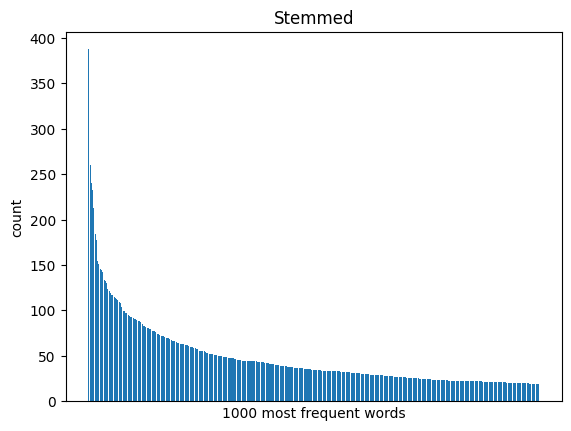

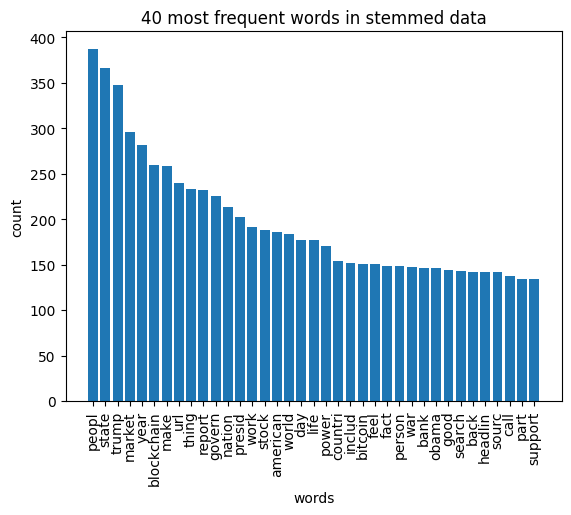

In [8]:
#exploration of vocabulary
#finding the most frequent words and plotting frequency distribution after tokenization, removal of stopwords and stemming
def most_frequent(series, from_value, to_value):
    '''returns a dictionary containing the
   "n" most frequent words in an interval - [from_value:to_value] - in the input series.'''
    return dict(vocabulary_size(series)[1][from_value:to_value])

#måske det her er hurtigere hvis man gør det med en dataframe?
most_frequent_tokenized = most_frequent(content_column_tokenized, 0, 49)
print("most frequent with stopwords", list(most_frequent_tokenized.keys()))

most_frequent_no_stopwords = most_frequent(content_column_no_stopwords, 0, 49)
print("most frequent without stopwords", list(most_frequent_no_stopwords.keys()))

most_frequent_stemmed = most_frequent(content_column_stemmed, 0, 49)
print("most frequent stemmed", list(most_frequent_stemmed.keys()))

#kig på hvorfor "a" ikke fjernes af stopword
#kig på hvorfor _number_ erstattes med number, og om det er ok med os
def word_frequency_plot(series, title):
    '''function for plotting from the third most frequent word to the 1000 most frequent word
    as well as their corresponding frequencies in a barplot.'''
    plt.bar(*zip(*most_frequent(series, 3, 1000).items())) #3 for at undgå  "a" og "number" men hvis det rettes skal der også rettes her
    plt.title(title)
    plt.xlabel('1000 most frequent words')
    plt.ylabel('count')
    plt.xticks(rotation=90)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.show()

word_frequency_plot(content_column_tokenized, 'Tokenized')
word_frequency_plot(content_column_no_stopwords, 'No Stopwords')
word_frequency_plot(content_column_stemmed, 'Stemmed')

frequent_stemwords = most_frequent(content_column_stemmed, 3, 40)

plt.bar(*zip(*frequent_stemwords.items()))
plt.xticks(rotation=90)
plt.title("40 most frequent words in stemmed data")
plt.xlabel('words')
plt.ylabel('count')
plt.show()
#stopwords gør at den ikke ikke har så vildt et peak for det mest frekvente ord - måske er det kun det originale datasæt der følger zipfs lov?
#kunne være fedt hvis man kunne plotte dem ved siden af hinanden. (Vi kan bruge subplot til det)
#emnerne ser ud til  at være politiske, finensielle/økonomiske

In [9]:
#træk informations-kategori og content ud i én dataframe
article_type = news_data['type']
news_data['type'] = news_data['type'].astype('category')

fakenews = set(['unreliable', 'fake', 'conspiracy'])
#overskydende er reliable, nan og unknown
def label_news(field):
    '''function for labeling news articles as either fake, reliable or unknown'''
    if field in fakenews:
        return 'fake'
    elif field == 'reliable':
        return 'reliable'
    else:
        return 'unknown'

news_data['simple_type'] = news_data['type'].apply(lambda x:label_news(x)).astype('category') #laver en ny kolonne med lidt simplere kategorier

print(news_data['type'].value_counts())
print(news_data['simple_type'].value_counts())


type
fake          155
conspiracy     31
political      23
bias            6
junksci         6
unknown         6
unreliable      6
reliable        3
clickbait       1
hate            1
Name: count, dtype: int64
simple_type
fake        192
unknown      43
reliable      3
Name: count, dtype: int64


scraping time statistics:
 count                            250
unique                             2
top       2018-01-25 16:17:44.789555
freq                             197
Name: scraped_at, dtype: object


<Axes: title={'center': 'Distribution of scraping times'}, xlabel='scraped_at', ylabel='count'>

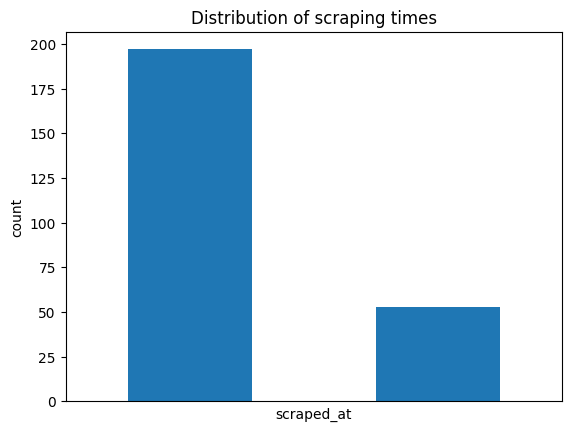

In [10]:
#More  exploration
print("scraping time statistics:\n", news_data['scraped_at'].describe())
#print("\n\n distribution: \n", news_data['scraped_at'].value_counts())
news_data["scraped_at"].to_frame().value_counts().plot(kind='bar',ylabel="count",title="Distribution of scraping times",xticks=[])
#dvs de er alle sammen indsamlet i 2018
#obs: det virker ikke muligt at finde ud af præcis hvornår hver enkelt artikel er fra? Det virker vigtigt



domains:
 count                   250
unique                   29
top       beforeitsnews.com
freq                    155
Name: domain, dtype: object


<Axes: title={'center': 'Distribution of domains'}, xlabel='domain', ylabel='count'>

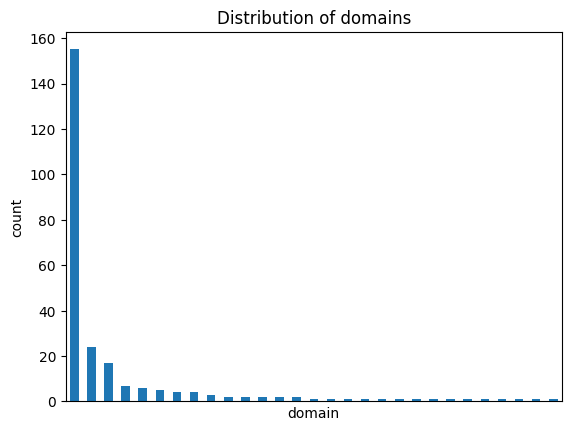

In [11]:
print("\ndomains:\n", news_data['domain'].describe())
news_data['domain'].to_frame().value_counts().plot(kind='bar',ylabel="count",xticks=[],title="Distribution of domains")
#obs: 155 af data kommer fra den samme, og generelt ikke særligt velfordelte kilder


authors:
 count            170
unique           109
top       John Rolls
freq              10
Name: authors, dtype: object


<Axes: xlabel='authors'>

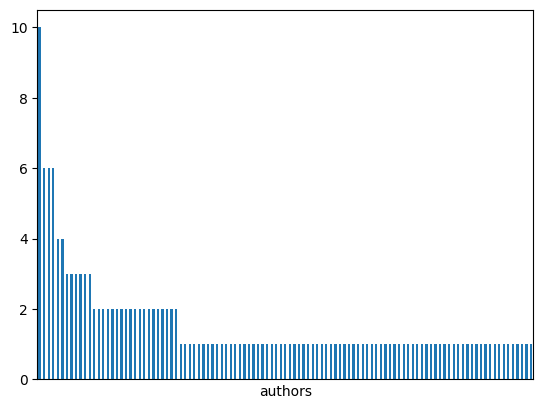

In [12]:
print("authors:\n", news_data['authors'].describe())
news_data['authors'].to_frame().value_counts().plot(kind='bar',xticks=[])
#ser lidt bedre ud her

simple_type
fake        Axes(0.125,0.11;0.775x0.77)
reliable    Axes(0.125,0.11;0.775x0.77)
unknown     Axes(0.125,0.11;0.775x0.77)
Name: mean_word_length, dtype: object

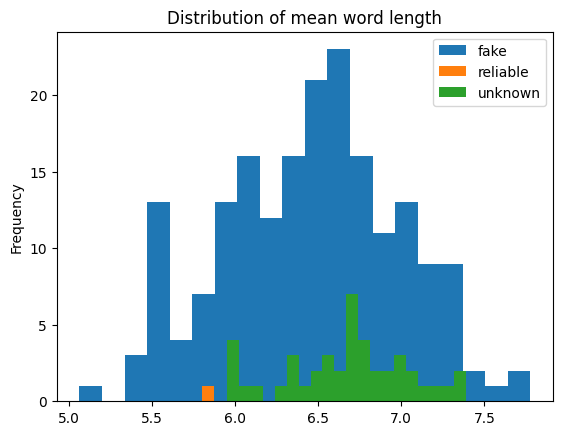

In [13]:
#Længde på ord, middelværdi og spredning
#alle plots kan også laves uden group-by hvis inddelingen ikke er så interessant
#vocabulary size/antal ord, middelværdi og spredning

def mean_length_of_words(wordlist):
    totallength = 0
    for word in wordlist:
        totallength = totallength + len(str(word))
    return totallength/len(wordlist)

def unique_words_ratio(wordlist):
    count = 0
    words = {}
    for word in wordlist:
        if word not in words:
            words[word]=1
            count +=1
    return count/len(wordlist)

news_data['mean_word_length']=content_column_no_stopwords.apply(lambda x:mean_length_of_words(x))

news_data.groupby('simple_type',observed=False)['mean_word_length'].plot(kind='hist',bins=20,title="Distribution of mean word length",legend=list("simple_type"))
#news_data["mean_word_length"].plot(kind="hist",bins=100) hvis den skal være uden gruppering
#det er måske en lidt mærkelig measure egentlig?

In [14]:
#news_data["mean_word_length"].describe()
news_data.groupby('type',observed=False)['mean_word_length'].describe()


,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
bias,6.0,6.491843,0.338671,6.076389,6.284308,6.453439,6.643863,7.032520
clickbait,1.0,6.130137,NaN,6.130137,6.130137,6.130137,6.130137,6.130137
conspiracy,31.0,6.562658,0.474517,5.445714,6.313938,6.537438,6.973795,7.255319
fake,155.0,6.444810,0.535648,5.062500,6.102689,6.500000,6.774144,7.776923
hate,1.0,6.782609,NaN,6.782609,6.782609,6.782609,6.782609,6.782609
junksci,6.0,6.979628,0.323195,6.666667,6.771919,6.838997,7.256150,7.388350
political,23.0,6.643682,0.347343,5.950000,6.522475,6.693215,6.854967,7.280899
reliable,3.0,6.496296,0.700029,5.800000,6.144444,6.488889,6.844444,7.200000
unknown,6.0,6.744350,0.471922,5.993007,6.472349,6.915233,7.071607,7.194175


In [15]:
news_data['unique_words_ratio']=content_column_no_stopwords.apply(lambda x:unique_words_ratio(x))
news_data.groupby('type')['unique_words_ratio'].describe()

C:\Users\astri\AppData\Local\Temp\ipykernel_11480\3536828274.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  news_data.groupby('type')['unique_words_ratio'].describe()


,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
bias,6.0,0.717553,0.086175,0.597855,0.652701,0.754286,0.774652,0.798611
clickbait,1.0,0.671233,NaN,0.671233,0.671233,0.671233,0.671233,0.671233
conspiracy,31.0,0.721893,0.083821,0.576577,0.662572,0.706383,0.750000,0.941176
fake,155.0,0.706153,0.136763,0.325095,0.623656,0.693820,0.803425,1.000000
hate,1.0,0.956522,NaN,0.956522,0.956522,0.956522,0.956522,0.956522
junksci,6.0,0.721669,0.137005,0.639769,0.669903,0.672030,0.675751,1.000000
political,23.0,0.716906,0.116851,0.508058,0.621247,0.740000,0.817720,0.900000
reliable,3.0,0.712394,0.076441,0.659259,0.668591,0.677922,0.738961,0.800000
unknown,6.0,0.593096,0.100929,0.430859,0.541534,0.628219,0.644633,0.708535


simple_type
fake        Axes(0.125,0.11;0.775x0.77)
reliable    Axes(0.125,0.11;0.775x0.77)
unknown     Axes(0.125,0.11;0.775x0.77)
Name: unique_words_ratio, dtype: object

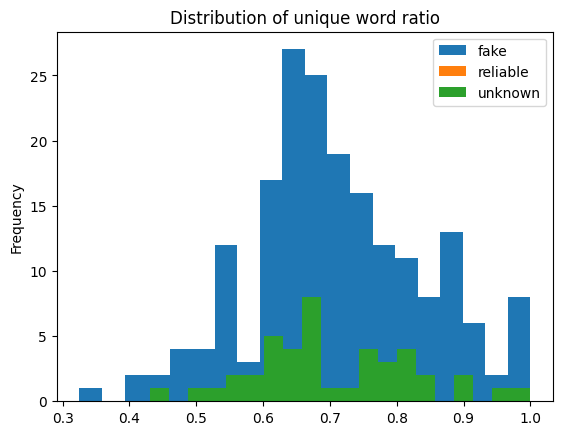

In [16]:
news_data.groupby('simple_type',observed=False)["unique_words_ratio"].plot(kind='hist',bins=20,title="Distribution of unique word ratio",legend=list("simple_type"))

In [17]:
#news_data["length"]=news_data["content_no_stopwords"].apply(lambda x: len(x))
#news_data.groupby('simple_type',observed=False)["length"].plot(kind='hist',bins=20,title="Distribution of length of articles",legend=list("simple_type"))

KeyError: 'content_no_stopwords'

In [18]:
#vil gerne have et histogran, der markerer for nogle bestemte ord, hvor stor en andel af artiklerne i kategorierne der indeholder ordet
news_data['content_no_stopwords']=content_column_no_stopwords
news_data['content_stemmed']=content_column_stemmed

#how many articles out of all articles mentions the topic?
def mention_ratio(topic,type):
    #gives mention ratio for whole column
    count = 0
    for field in news_data[news_data.type==type]['content_no_stopwords']:
        if topic in field:
            count+=1
    return count/len(news_data[news_data.type==type])
    #man kunne måske også få en fordeling?

print('"trump" mention, fake:', mention_ratio("trump","fake"))
print('"trump" mention, reliable:', mention_ratio("trump","reliable"))
print('"reseach" mention, fake:', mention_ratio("research","fake"))
print('"reseach" mention, reliable:', mention_ratio("research","reliable"))
#man kan lave nogle flere

"trump" mention, fake: 0.8516129032258064
"trump" mention, reliable: 0.0
"reseach" mention, fake: 0.16129032258064516
"reseach" mention, reliable: 0.3333333333333333


In [20]:
print(type([news_data["content_stemmed"][0]]))

<class 'list'>


simple_type
fake        Axes(0.125,0.11;0.775x0.77)
reliable    Axes(0.125,0.11;0.775x0.77)
unknown     Axes(0.125,0.11;0.775x0.77)
Name: numbers, dtype: object

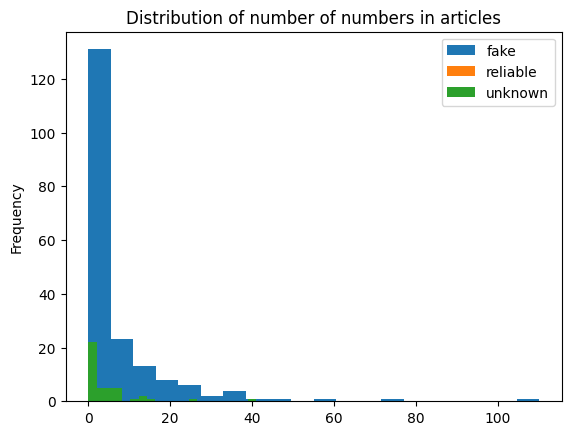

In [21]:
#count number of numbers
news_data["numbers"]=news_data["content_stemmed"].apply(lambda x:Counter(x)["number"])
news_data.groupby('simple_type',observed=False)["numbers"].plot(kind='hist',bins=20,title="Distribution of number of numbers in articles",legend=list("simple_type"))


In [22]:
news_data.to_csv('small_datasetprocessed.csv', index=True)
print(list(news_data))

['Unnamed: 0', 'id', 'domain', 'type', 'url', 'content', 'scraped_at', 'inserted_at', 'updated_at', 'title', 'authors', 'keywords', 'meta_keywords', 'meta_description', 'tags', 'summary', 'simple_type', 'mean_word_length', 'unique_words_ratio', 'content_no_stopwords', 'content_stemmed', 'numbers']


In [23]:
news_data.to_pickle("small_data_pickle")
